# Question 13
In this notebook we address question 3 of Lab5+6. For this purpose we will explore the data over years to confirm or nuance the observations we made on year 1994. We will then gather more data, data about the airports (state and zip code), about the planes,  daily weather data (at airports) and maybe more.

# Part 3
# Period 1993-1996, data exploration

In [110]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import time as time

from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint

# to start testing, we can focus on a single year
# input_path = "/datasets/airline/1994.csv"
base = "/Users/quentinleroy/Documents/Eurecom/AML/Lab5+6/air_delays/"
raw_data_1993 = sc.textFile(base + "1993.csv")
raw_data_1994 = sc.textFile(base + "1994.csv")
raw_data_1995 = sc.textFile(base + "1995.csv")
raw_data_1996 = sc.textFile(base + "1996.csv")

In [111]:
raw_data = raw_data_1993.union(raw_data_1994).union(raw_data_1995).union(raw_data_1996)

In [112]:
# extract the header
header = raw_data_1993.first()

def deleteNA(row):
    line = row.split(",")
    for (i,col) in enumerate(line):
        if col=='NA':
            line[i]=''
    return ','.join(line)

# replace invalid data with NULL and remove header
cleaned_data = (raw_data\
        # filter out the header
        .filter(lambda row: row!=header)
        # replace the missing values with empty characters
        .map(lambda row: deleteNA(row))
        )
        
#print("number of rows after cleaning:", raw_data.count())

In [113]:
sqlContext = SQLContext(sc)

# Declare the data schema
# see http://stat-computing.org/dataexpo/2009/the-data.html
# for more information
airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(), True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

In [114]:
# convert each line into a tuple of features (columns)

def data_to_columns(cols):
    return (int(cols[0])  if cols[0] else None,
            int(cols[1])  if cols[1] else None,
            int(cols[2])  if cols[2] else None,
            int(cols[3])  if cols[3] else None,
            int(cols[4])  if cols[4] else None,
            int(cols[5])  if cols[5] else None,
            int(cols[6])  if cols[6] else None,
            int(cols[7])  if cols[7] else None,
            cols[8]       if cols[8] else None,
            cols[9]       if cols[9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         )
cleaned_data_to_columns = cleaned_data.map(lambda l: l.split(","))\
    .map(lambda cols: data_to_columns(cols))

In [115]:
# create dataframe df
df = (sqlContext.createDataFrame(cleaned_data_to_columns, schema = airline_data_schema)
        .select(["year", "month", "day_of_month", "day_of_week", \
                "departure_time", "scheduled_departure_time","arrival_time",\
                 "scheduled_arrival_time","arrival_delay", "departure_delay",\
                 "src_airport", "dest_airport", "carrier", "distance"])
        .cache()
    )

In [116]:
df = df.withColumn('hour', round(df.scheduled_departure_time/100, 0))
df = df.withColumn('is_delay', when(df["arrival_delay"] >= 15, 1).otherwise(0))

In [65]:
t0 = time.time()
statistic_month = df.groupBy("month").count().collect()
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

finish in 678.477868 seconds


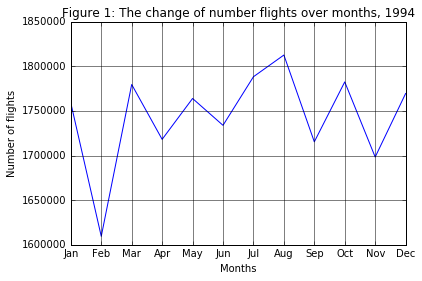

In [67]:
pdf = pd.DataFrame(data=statistic_month)
plt.xlabel("Months")
plt.ylabel("Number of flights")
plt.title('Figure 1: The change of number flights over months, 1993-1996')
plt.grid(True,which="both",ls="-")
plt.plot(pdf[0], pdf[1])
plt.xlim(1,12)
plt.xticks(range(1,13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

In [68]:
t0 = time.time()
statistic_day_of_week = df.groupBy("day_of_week").count().collect()
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

finish in 8.808654 seconds


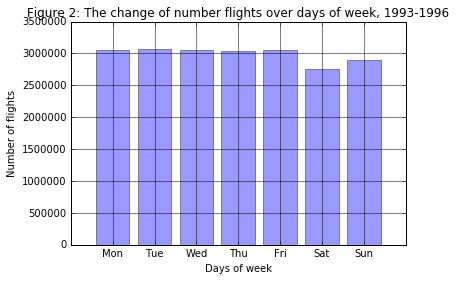

In [72]:
#statistic_day_of_week.show()
pdf = pd.DataFrame(data=statistic_day_of_week)
plt.xlabel("Days of week")
plt.ylabel("Number of flights")
plt.title('Figure 2: The change of number flights over days of week, 1993-1996')
plt.grid(True,which="both",ls="-")
map_int_into_day = { 1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat", 7:"Sun" }
day_of_week_label = pdf[0].map(lambda i: map_int_into_day[i])

# plot bar chart
plt.bar(pdf[0], pdf[1], align="center", alpha = 0.4)

plt.xticks(pdf[0], day_of_week_label)
plt.show()


In [70]:
t0 = time.time()
statistic_day_of_month = df.groupBy("day_of_month").count().collect()
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

finish in 7.629210 seconds


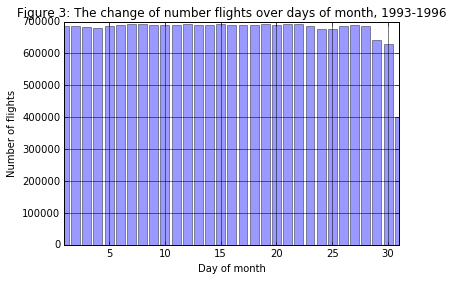

In [73]:
#statistic_day_of_month.show()
pdf = pd.DataFrame(data=statistic_day_of_month)
# plot bar chart
plt.bar(pdf[0], pdf[1], align = 'center', alpha = 0.4)
plt.xlim(1,31)
plt.title("Figure 3: The change of number flights over days of month, 1993-1996")
plt.grid(True, which="both", ls="-")
plt.xlabel("Day of month")
plt.ylabel("Number of flights")
plt.show()

In [74]:
t0 = time.time()
statistic_hour_of_day = df.groupBy("hour").count().collect()
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

finish in 9.714251 seconds


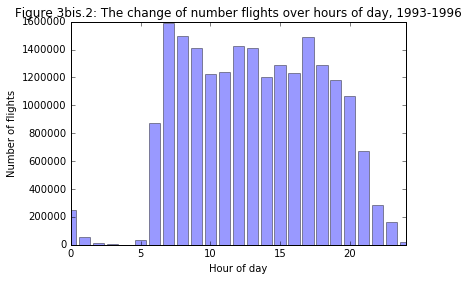

In [76]:
#statistic_hour_of_day.show()
pdf = pd.DataFrame(data=statistic_hour_of_day)

#plot char chart
plt.bar(pdf[0], pdf[1], align="center", alpha=0.4)

plt.title('Figure 3bis.2: The change of number flights over hours of day, 1993-1996')
plt.xlabel("Hour of day")
plt.ylabel("Number of flights")
plt.xlim(0,24)
plt.xticks()
plt.show()

In [78]:
# group by year and hour
statistic_delay_hour = df.groupBy("hour")

# calculate the delay ratio and create a new column
delay_ratio_per_hour = statistic_delay_hour.agg(
    (func.sum('is_delay')/func.count('*')).alias('delay_ratio')
)

    
# order the result by hour
delay_ratio_per_hour = (
            delay_ratio_per_hour
                .orderBy('hour')
                .select(['hour', 'delay_ratio'])
    )

pdf_delay_ratio_per_hour = pd.DataFrame(data=delay_ratio_per_hour.collect())

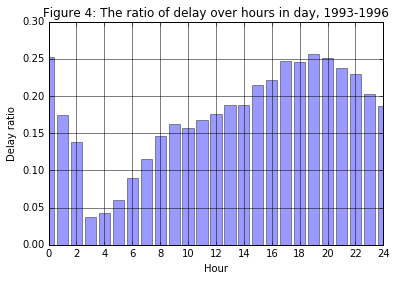

In [80]:
# plot a bar chart
plt.bar(pdf_delay_ratio_per_hour[0], pdf_delay_ratio_per_hour[1], align="center", alpha=0.4)
plt.xlim(0,24)
plt.xlabel('Hour')
plt.ylabel('Delay ratio')
plt.grid(True,which="both",ls="-")
plt.xticks(range(0,25,2), [str(i) for i in range(0,25,2)])
plt.title('Figure 4: The ratio of delay over hours in day, 1993-1996')
plt.show()

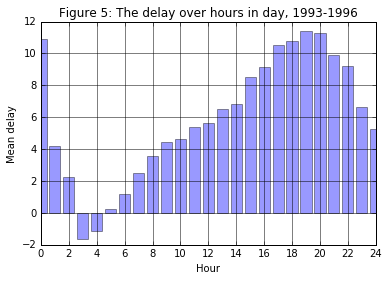

In [84]:
mean_delay_per_hour = statistic_delay_hour.agg(
    (func.mean('arrival_delay')).alias('mean_delay')
)
    
mean_delay_per_hour = (
    mean_delay_per_hour
        .orderBy('hour')
        .select(['hour', 'mean_delay'])
    )
    
pdf_mean_delay_per_hour = pd.DataFrame(data=mean_delay_per_hour.collect())

plt.bar(pdf_mean_delay_per_hour[0], pdf_mean_delay_per_hour[1], align="center", alpha=0.4)
plt.xlim(0,24)
plt.xlabel('Hour')
plt.ylabel('Mean delay')
plt.grid(True,which="both",ls="-")
plt.xticks(range(0,25,2), [str(i) for i in range(0,25,2)])
plt.title('Figure 5: The delay over hours in day, 1993-1996')
plt.show()

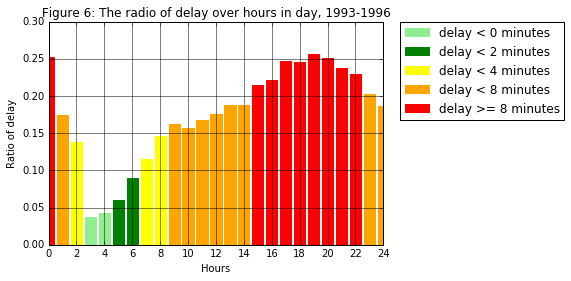

In [83]:
#pdf2 = pd.DataFrame(data=mean_delay_per_hour.collect())
plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 6: The radio of delay over hours in day, 1993-1996')
plt.grid(True,which="both",ls="-")
bars = plt.bar(pdf_delay_ratio_per_hour[0], pdf_delay_ratio_per_hour[1], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if pdf_mean_delay_per_hour[1][i] < 0:
        color = 'lightgreen'
    elif pdf_mean_delay_per_hour[1][i] < 2:
        color = 'green'
    elif pdf_mean_delay_per_hour[1][i] < 4:
        color = 'yellow'
    elif pdf_mean_delay_per_hour[1][i] < 8:
        color = 'orange'
    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='delay < 0 minutes')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,24)
plt.xticks(range(0,25,2), [str(i) for i in range(0,25,2)])
plt.show()

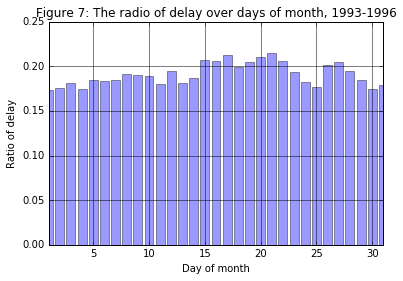

In [86]:
####### The changes of delay ratio over days of month ########
# calculate the delay ratio in each day of month
statistic_day_of_month = (
    df
        .groupBy("day_of_month")
        .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
        # order by day_of_month
        .orderBy("day_of_month")
    )
    
# collect data and plot
pdf_day_of_month = pd.DataFrame(data=statistic_day_of_month.collect())
plt.bar(pdf_day_of_month[0], pdf_day_of_month[1], align="center", alpha=0.4)
plt.grid(True,which="both",ls="-")
plt.xlabel("Day of month")
plt.ylabel("Ratio of delay")
plt.title('Figure 7: The radio of delay over days of month, 1993-1996')
plt.xlim(1,31)
plt.show()

In [88]:
pdf_day_of_month

,0,1
0,1,0.173002
1,2,0.176019
2,3,0.180677
3,4,0.174695
4,5,0.184183
5,6,0.183185
6,7,0.184383
7,8,0.191018
8,9,0.189649
9,10,0.188676


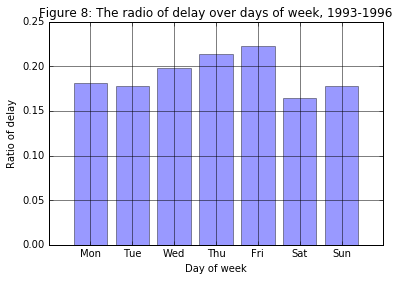

In [89]:
####### The changes of delay ratio over days of week ########
# calculate the delay ratio in each day of week
statistic_day_of_week = (
    df
        .groupBy("day_of_week")
        .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
        .orderBy("day_of_week")
    )
    
# collect data and plot
pdf_day_of_week = pd.DataFrame(data=statistic_day_of_week.collect())
map_int_into_day = { 1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat", 7:"Sun" }
day_of_week_label = pdf_day_of_week[0].map(lambda i: map_int_into_day[i])

plt.bar(pdf_day_of_week[0], pdf_day_of_week[1], align="center", alpha=0.4)
plt.grid(True,which="both",ls="-")
plt.xlabel("Day of week")
plt.ylabel("Ratio of delay")
plt.title('Figure 8: The radio of delay over days of week, 1993-1996')
plt.xticks(pdf_day_of_week[0], day_of_week_label)
plt.show()

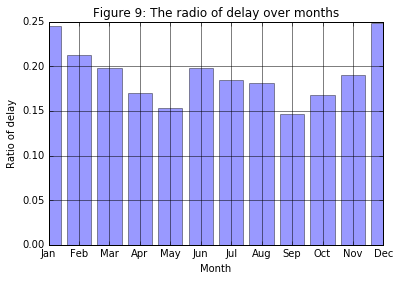

In [90]:
####### The changes of delay ratio over months ########
# calculate the delay ratio in month
statistic_month = (
    df
    .groupBy("month")
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
    .orderBy("month")
    )
    
# collect data and plot
pdf_month = pd.DataFrame(data=statistic_month.collect())
plt.bar(pdf_month[0], pdf_month[1], align="center", alpha=0.4)
plt.grid(True,which="both",ls="-")
plt.xlabel("Month")
plt.ylabel("Ratio of delay")
plt.xlim(1,12)
plt.title('Figure 9: The radio of delay over months, 1993-1996')
plt.xticks(range(1,13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

## Incidence of departure_delay over arrival_delay

Here, we'll try to see if the delay is caused by incidents before the plane is leaving or if those incidents occures during the flight.

In [117]:
delay_departure_by_minute = df.groupBy("departure_delay")
delay_ratio_per_departure_delay = delay_departure_by_minute.agg(
    (func.sum('arrival_delay')/func.count('*')).alias('average_delay')
)

delay_ratio_per_departure_delay = (
            delay_ratio_per_departure_delay
                .orderBy('departure_delay')
                .select(['departure_delay', 'average_delay'])
    )

pdf_delay_ratio_per_departure_delay = pd.DataFrame(data=delay_ratio_per_departure_delay.collect())

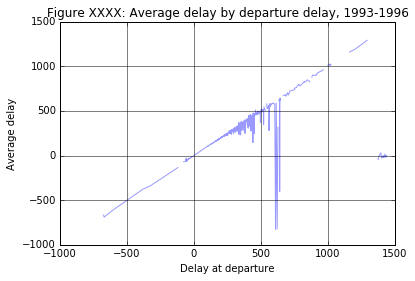

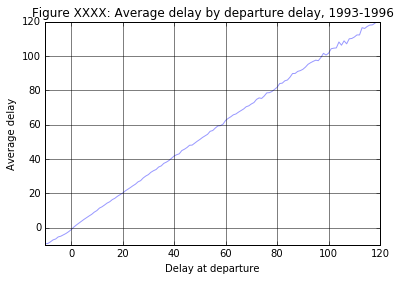

In [105]:
plt.plot(pdf_delay_ratio_per_departure_delay[0], pdf_delay_ratio_per_departure_delay[1], alpha=0.4)
plt.xlabel('Delay at departure')
plt.ylabel('Average delay')
plt.grid(True,which="both",ls="-")
#plt.xticks(range(-10,121,10), [str(i) for i in range(-10,121,10)])
plt.title('Figure XXXX: Average delay by departure delay, 1993-1996')
plt.show()

plt.plot(pdf_delay_ratio_per_departure_delay[0], pdf_delay_ratio_per_departure_delay[1], alpha=0.4)
plt.xlabel('Delay at departure')
plt.ylabel('Average delay')
plt.xlim(-10, 120)
plt.ylim(-10, 120)
plt.grid(True,which="both",ls="-")
#plt.xticks(range(-10,121,10), [str(i) for i in range(-10,121,10)])
plt.title('Figure XXXX: Average delay by departure delay, 1993-1996')
plt.show()

In [118]:
statistic_departure_delay = df.groupBy("departure_delay").count().orderBy("departure_delay").collect()
statistic_arrival_delay = df.groupBy("arrival_delay").count().orderBy("arrival_delay").collect()

pdf_departure_delay = pd.DataFrame(data=statistic_departure_delay)
pdf_arrival_delay = pd.DataFrame(data=statistic_departure_delay)

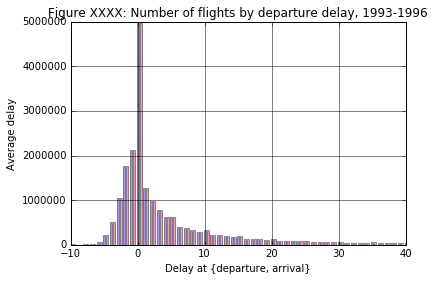

In [119]:
bar_width=0.3
plt.bar(pdf_departure_delay[0], pdf_departure_delay[1], bar_width, align="center", color="blue", alpha=0.4)
plt.bar(pdf_arrival_delay[0]+1.5*bar_width, pdf_arrival_delay[1], bar_width, align="center", color="red", alpha=0.4)

plt.xlabel('Delay at {departure, arrival}')
plt.ylabel('Average delay')
plt.grid(True,which="both",ls="-")
plt.xlim(-10, 40)
# plt.xticks(range(-10,121,10), [str(i) for i in range(-10,121,10)])
plt.title('Figure XXXX: Number of flights by departure delay, 1993-1996')
plt.show()

In [120]:
total_flights = df.count()
print("During period 1993-1996, among ", total_flights, " flights")
print("\t", df[df.departure_delay>120].count(), "flights departed more than 120 minutes late")
print("\t", df[df.departure_delay<-10].count(), "flight departed more than 10 minutes early")
print("\t", df[df.arrival_delay>120].count(), "flights departed more than 120 minutes late")
print("\t", df[df.arrival_delay<-10].count(), "flight departed more than 10 minutes early")

During period 1993-1996, among  20929967  flights
	 160222 flights departed more than 120 minutes late
	 17028 flight departed more than 10 minutes early
	 188182 flights departed more than 120 minutes late
	 2233318 flight departed more than 10 minutes early


# Part 4
## Work to do in this part

In [7]:
# select distinct {source airports, destination airports, carriers} and map values to index
# sort the {src_airport, dest_airport, carrier} by their frequency descending
# so the most common {src_aiport, dest_airport, carrier} will be on the top
stat_src = (
    df
        .groupBy("src_airport")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    )

stat_dest = (
    df
        .groupBy("dest_airport")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    )

stat_carrier = (
    df
        .groupBy("carrier")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    )

# extract the {src_airport, dest_airport, carrier} names from {stat_src, stat_dest, stat_carrier}
src_airports = [item[0] for item in stat_src.collect()]
dest_airports = [item[0] for item in stat_dest.collect()]
carriers = [item[0] for item in stat_carrier.collect()]

num_src_airports = len(src_airports)
num_dest_airports = len(dest_airports)
num_carriers = len(carriers)


src_airports_idx = range(0, num_src_airports)
dest_airport_idx = range(0, num_dest_airports)
carrier_idx = range(0, num_carriers)

map_src_airport_to_index = dict(zip(src_airports, src_airports_idx))
map_dest_airport_to_index = dict(zip(dest_airports, dest_airport_idx))
map_carrier_to_index = dict(zip(carriers, carrier_idx))

Find most common values for categorical features (`month`, `day_of_month`, `day_of_week`, `scheduled_departure_time`, `scheduled_arrival_time`) and mean values for numerical features (`distance`, `arrival_delay`)

In [ ]:
the_most_common_month = (
    df
        .groupBy("month")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

the_most_common_day_of_month = (
    df
        .groupBy("day_of_month")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

the_most_common_day_of_week = (
    df
        .groupBy("day_of_week")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

the_most_common_s_departure_time = (df
        .groupBy("scheduled_departure_time")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

the_most_common_s_arrival_time =  (df
        .groupBy("scheduled_arrival_time")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

mean_distance = df.groupBy().agg((func.sum("distance")/func.count("*")).alias("mean")).collect()[0].mean

mean_arrival_delay = df.groupBy().agg((func.sum("arrival_delay")/func.count("*")).alias("mean")).collect()[0].mean

print("The most common month:", the_most_common_month)
print("The most common day of month:", the_most_common_day_of_month)
print("The most common day of week:", the_most_common_day_of_week)
print("The most common scheduled departure time:", the_most_common_s_departure_time)
print("The most common scheduled arrival time:", the_most_common_s_arrival_time)
print("mean distance:", mean_distance)
print("mean arrival delay:", mean_arrival_delay)



Prepare data (RDD) with chosen features, replace missing values by most common values (categorical features) or mean values (numerical features). Split the data into trainingData (`70%`) and testData (`30%`)

In [8]:
def is_valid(value):
    return value != "NA" and len(value) > 0

data = cleaned_data\
    .map(lambda line: line.split(','))\
    .map(lambda values: 
        LabeledPoint( 
            int(values[14]) if is_valid(values[14]) else mean_arrival_delay, # arrival delay
            [
                int(values[0]), # year
                int(values[1]) if is_valid(values[1]) else most_common_month, # month
                int(values[2]) if is_valid(values[2]) else the_most_common_day_of_month, # day of month
                int(values[3]) if is_valid(values[3]) else the_most_common_day_of_week, # day of week
                int(values[5]) if is_valid(values[5]) else the_most_common_s_departure_time , # scheduled departure time
                int(values[7]) if is_valid(values[7]) else the_most_common_s_arrival_time, # scheduled arrival time
                # if the value is valid, map it to the corresponding index
                # otherwise, use the most common value
                map_carrier_to_index[values[8]] if is_valid(values[8]) \
                    else map_carriers_to_index[carriers[0]], # carrier
                map_src_airport_to_index[values[16]] if is_valid(values[16]) 
                    else map_src_airport_to_index[src_airports[0]], # src_airport
                map_dest_airport_to_index[values[17]] if is_valid(values[17])
                    else map_dest_airport_to_index[dest_airports[0]], # destination_airport
                int(values[18]) if is_valid(values[18]) else mean_distance, # distance
                1 if is_valid(values[3]) and int(values[3]) >= 6 else 0, # is_weekend
            ]
        )
    )

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

We can train a decision model by using function `DecisionTree.trainRegressor(<training_data>, categoricalFeaturesInfo=<categorical_info>, impurity=<impurity_function>,  maxDepth=<max_depth>, maxBins=<max_bins>)`.

Where,

* `training_data` : the data used for training
* `categorical_info` : a dictionary that maps the index of each categorical features to its number of distince values
* `impurity_function` : the function that is used to calculate impurity of data in order to select the best split
* `max_depth`: the maximum depth of the tree
* `max_bins`: the maximum number of bins that the algorithm will divide on each feature. Note that, `max_bins` can not smaller than the number distinct values of every categorical features.

Complete the code below to train a decision tree model.


In [ ]:
# declare information of categorical features
# format:  feature_index : number_distinct_values
categorical_info = {6 : num_carriers, 7: num_src_airports, 8: num_dest_airports, 10: 2}
t0 = time.time()
# Train a DecisionTree model.
model = DecisionTree.trainRegressor(trainingData, 
                                    categoricalFeaturesInfo=categorical_info,
                                    impurity='variance', maxDepth=12, maxBins=255)
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

In [122]:
%pwd

'/Users/quentinleroy/Documents/Eurecom/Algorithmic-Machine-Learning/Work-gabriel'